<div align='center'><img src="https://i.ytimg.com/vi/U-SBY9eJ-xc/maxresdefault.jpg" width=900></div>

## CNN based traffic sign recognition system

In [1]:
#to show detailes of architecture of the model and each layer and it's shape 
!pip install torchsummary

In [7]:
!pip install tensorboard

  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached Markdown-3.6-py3-none-any.whl.metadata (7.0 kB)
  Using cached protobuf-4.25.3-cp310-abi3-win_amd64.whl.metadata (541 bytes)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached werkzeug-3.0.3-py3-none-any.whl.metadata (3.7 kB)
   ---------------------------------------- 0.0/5.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.5 MB 330.3 kB/s eta 0:00:17
   ---------------------------------------- 0.0/5.5 MB 330.3 kB/s eta 0:00:17
   ---------------------------------------- 0.0/5.5 MB 330.3 kB/s eta 0:00:17
   ---------------------------------------- 0.0/5.5 MB 131.3 kB/s eta 0:00:42
   ---------------------------------------- 0.0/5.5 MB 131.3 kB/s eta 0:00:42
   ---------------------------------------- 0.1/5.5 MB 182.2 kB/s eta 0:00:30
    --------------------------------------- 0

In [3]:
#to check if the CUDA is available,if it's available this code should return:TRUE
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

CUDA available: True


#### Import Libraries and APIs

In [ ]:
import torch
import gc, os, cv2, PIL
import torchvision as tv
import torch.nn as nn
import torchsummary as ts
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

### Read the labels.csv file that contains metadata on traffic sign labels 

In [5]:
labels_df = pd.read_csv('C:\\Users\\Alireza217\\Desktop\\traffic\\labels.csv')
labels_df

ClassId                                               Name
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                               Stop
15       15                                        No vechiles
16       16           Vechiles over 3.5 metric tons prohibited
17       17                                           No entry
18       18                                    General caution
19       19                        Dangerous curve to the left
20       20                       Dangerous curve to the right
21       21                                       Double curve
22       22                                         Bumpy road
23       23                                      Slippery road
24       24                          Road narrows on the right
25       25                                          Road work
26       26                                    Traffic signals
27       27                                        Pedestrians
28       28                                  Children crossing
29       29                                  Bicycles crossing
30       30                                 Beware of ice/snow
31       31                              Wild animals crossing
32       32                End of all speed and passing limits
33       33                                   Turn right ahead
34       34                                    Turn left ahead
35       35                                         Ahead only
36       36                               Go straight or right
37       37                                Go straight or left
38       38                                         Keep right
39       39                                          Keep left
40       40                               Roundabout mandatory
41       41                                  End of no passing
42       42  End of no passing by vechiles over 3.5 metric ...

### Import the dataset of Images along with the labels that are needed to train and test the model

In [6]:
%%time 
# %%time used to calculate total time taken to execute the cell
x , y = [] , []  # X to store images and y to store respective labels  
data_dir = 'C:\\Users\\Alireza217\\Desktop\\traffic\\myData'
for folder in range(43):
    folder_path = os.path.join(data_dir,str(folder)) # os.path.join just join both string 
    for i,img in enumerate(os.listdir(folder_path)):
        img_path = os.path.join(folder_path,img)
        # PIL load the image as PIL object and ToTensor() convert this to a Tensor
        img_tensor = tv.transforms.ToTensor()(PIL.Image.open(img_path))
        x.append(img_tensor.tolist()) # convert the tensor to list of list and append
        y.append(folder)
    print('folder of label',folder,'images loaded. Number of samples :',i+1)
x = np.array(x)
y = np.array(y)

folder of label 0 images loaded. Number of samples : 451
folder of label 1 images loaded. Number of samples : 4920
folder of label 2 images loaded. Number of samples : 2610
folder of label 3 images loaded. Number of samples : 2670
folder of label 4 images loaded. Number of samples : 3750
folder of label 5 images loaded. Number of samples : 3510
folder of label 6 images loaded. Number of samples : 780
folder of label 7 images loaded. Number of samples : 2730
folder of label 8 images loaded. Number of samples : 2670
folder of label 9 images loaded. Number of samples : 2790
folder of label 10 images loaded. Number of samples : 3810
folder of label 11 images loaded. Number of samples : 2490
folder of label 12 images loaded. Number of samples : 3990
folder of label 13 images loaded. Number of samples : 4080
folder of label 14 images loaded. Number of samples : 1470
folder of label 15 images loaded. Number of samples : 1170
folder of label 16 images loaded. Number of samples : 780
folder of 

### Handling Imbalanced Dataset

##### Check - dataset is balanced or not

In [7]:
# np.unique returns all the labels as one array and 
#number of samples available respect to that label as another array.
np.unique(y,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 array([ 451, 4920, 2610, 2670, 3750, 3510,  780, 2730, 2670, 2790, 3810,
        2490, 3990, 4080, 1470, 1170,  780, 2100, 2280,  390,  660,  600,
         720,  960,  510, 2850, 1140,  450, 1020,  510,  840, 1470,  450,
        1288,  780, 2280,  720,  390, 3930,  570,  660,  450,  450],
       dtype=int64))

So as per the above result , the dataset is very imbalanced and needed to be balanced.

##### Apply Over Sampling to balance the dataset

In [8]:
x = x.reshape(x.shape[0],3*32*32) # flatten x as RandomOverSampler only accepts 2-D matrix
# RandomOverSampler method duplicates samples in the minority class to balance dataset
x,y = RandomOverSampler().fit_resample(x,y)
x = x.reshape(x.shape[0],3,32,32) # reshaped again as it was
x.shape, y.shape

((211560, 3, 32, 32), (211560,))

##### Check again - dataset is balanced or not

In [9]:
np.unique(y,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 array([4920, 4920, 4920, 4920, 4920, 4920, 4920, 4920, 4920, 4920, 4920,
        4920, 4920, 4920, 4920, 4920, 4920, 4920, 4920, 4920, 4920, 4920,
        4920, 4920, 4920, 4920, 4920, 4920, 4920, 4920, 4920, 4920, 4920,
        4920, 4920, 4920, 4920, 4920, 4920, 4920, 4920, 4920, 4920],
       dtype=int64))

So now the dataset is balanced. Now split the dataset for training and testing 

#### Split dataset for training and testing

In [10]:
# Stratified split on the dataset 
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,stratify=y)
del x,y
gc.collect() # delete x,y and free the memory 
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape # splited data shapes

((169248, 3, 32, 32), (42312, 3, 32, 32), (169248,), (42312,))

#### Show 100 Images from train samples as a Grid using matplotlib

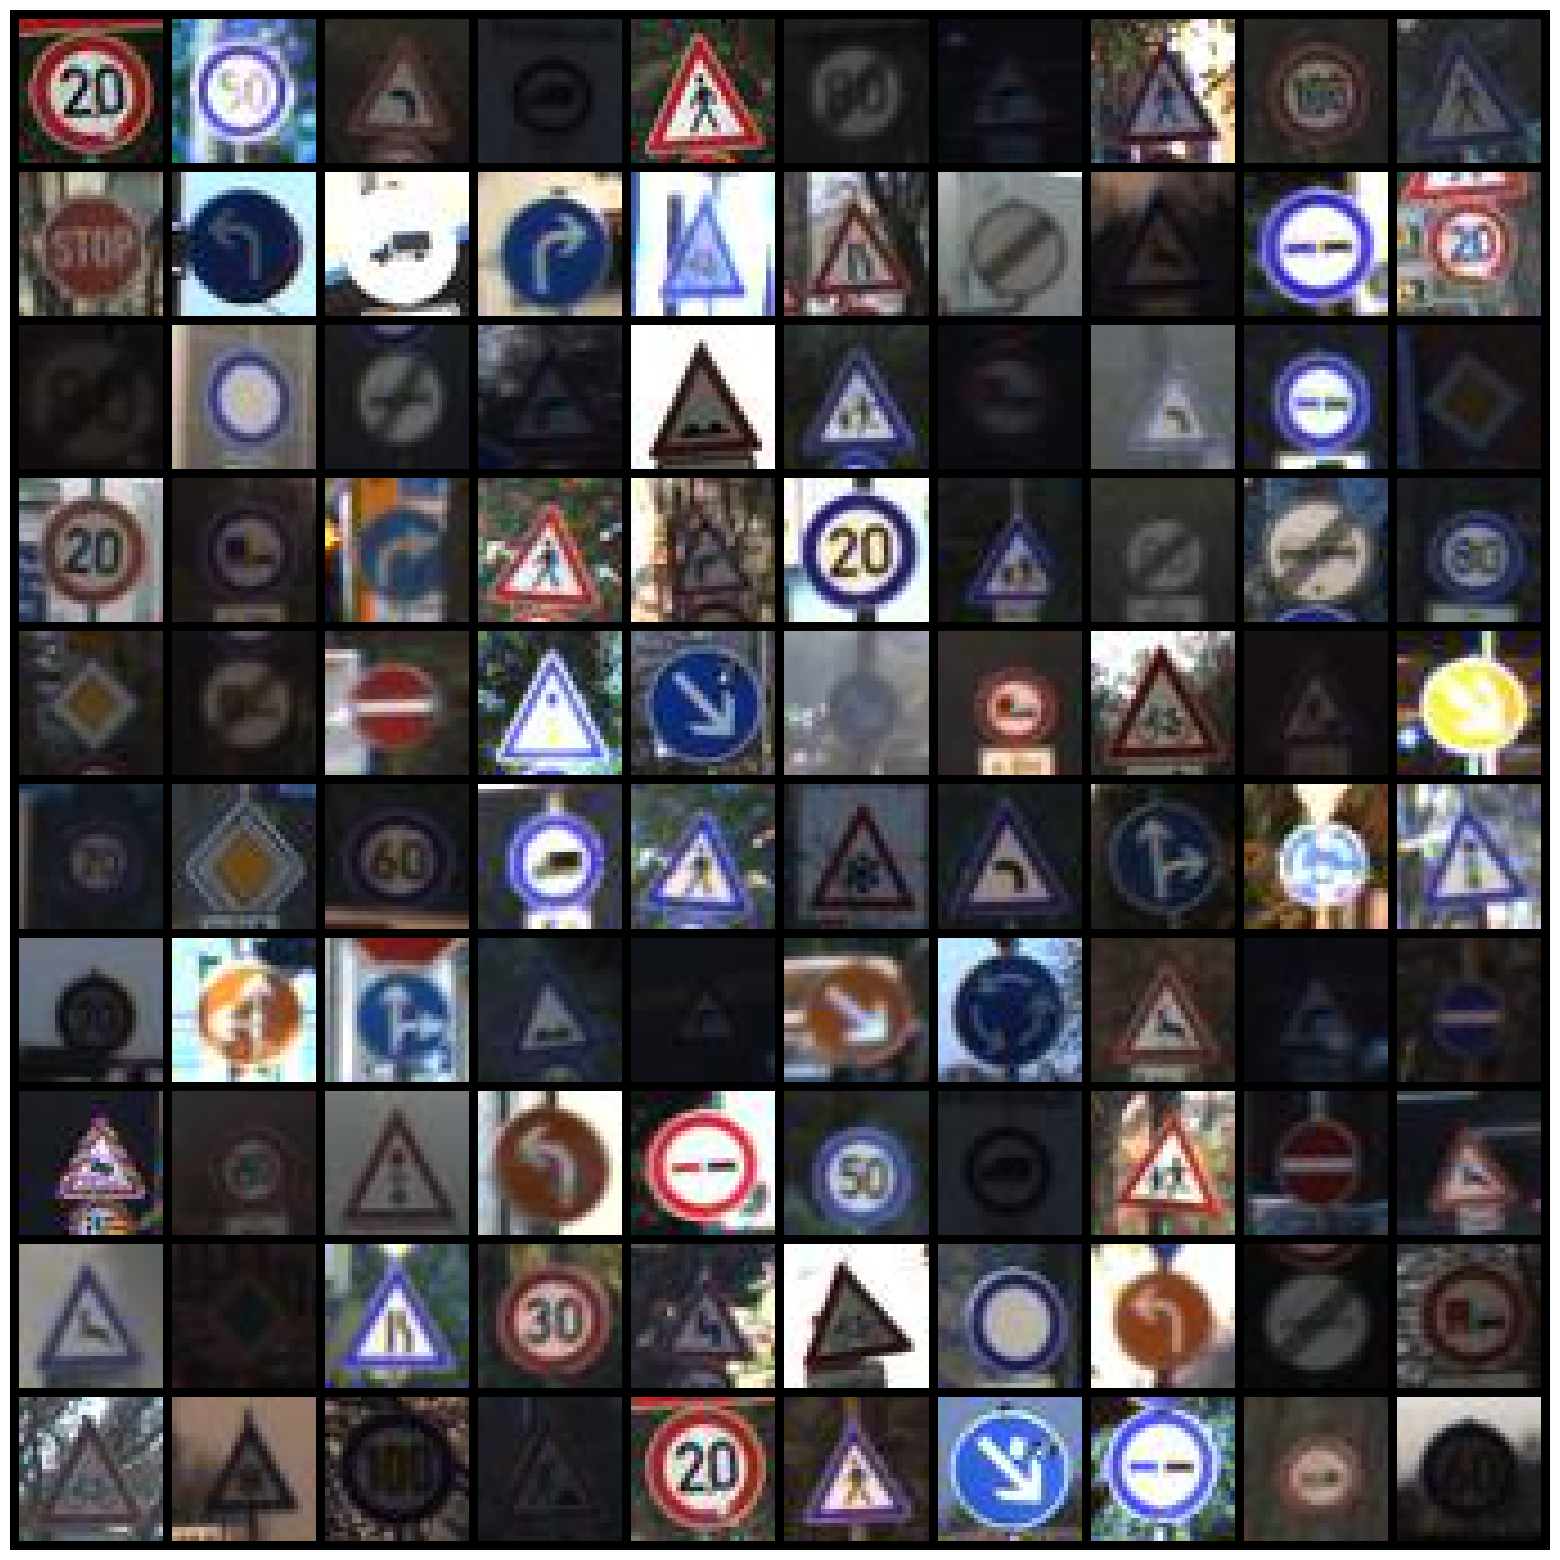



Labels of the above images :



array([ 0,  2, 19, 16, 27,  6, 20, 27,  7, 27, 14, 34, 16, 33, 29, 24, 32,
       31,  9,  0,  6, 15, 41, 20, 22, 28, 10, 19,  9, 12,  0, 10, 33, 27,
       20,  0, 28,  6, 41,  5, 12, 42, 17, 26, 38, 38, 10, 29, 25, 38,  4,
       12,  3, 16, 27, 30, 19, 36, 40, 26,  4, 37, 36, 22, 20, 38, 40, 31,
       20, 17, 23,  5, 26, 34,  9,  2, 16, 28, 17, 31, 31, 12, 24,  1, 21,
       29, 15, 34, 41, 10, 29, 30,  7, 25,  0, 27, 38,  9,  9,  3])

In [11]:
plt.figure(figsize=(20,20)) 
# make_grid creates a grid of 100 images and show it
plt.imshow(tv.utils.make_grid(torch.tensor(xtrain[:100]),nrow=10).permute(1,2,0))
plt.axis('off') # To remove xticks and yticks
plt.show()
print('\n\nLabels of the above images :\n')
ytrain[:100]

### Convert train and test data from numpy array to tensor for further computations

In [12]:
xtrain = torch.from_numpy(xtrain) 
ytrain = torch.from_numpy(ytrain)
xtest = torch.from_numpy(xtest)
ytest = torch.from_numpy(ytest)

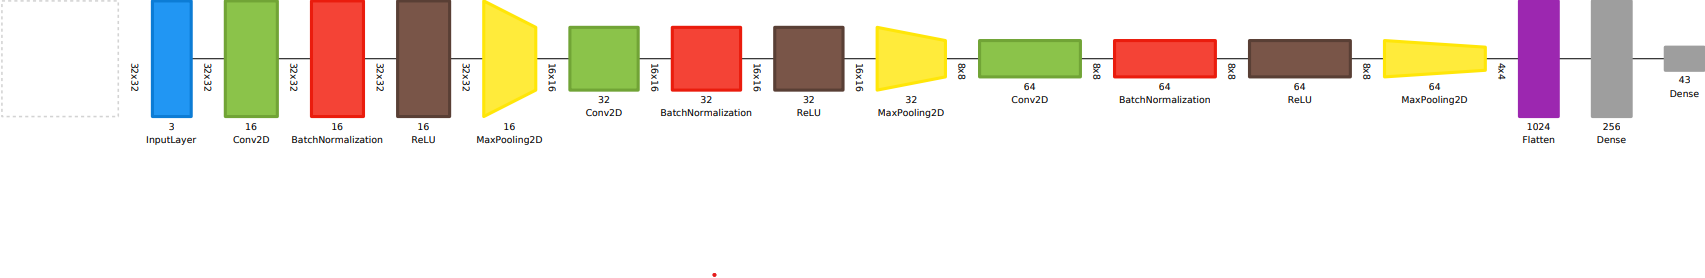

## Convolution Operation

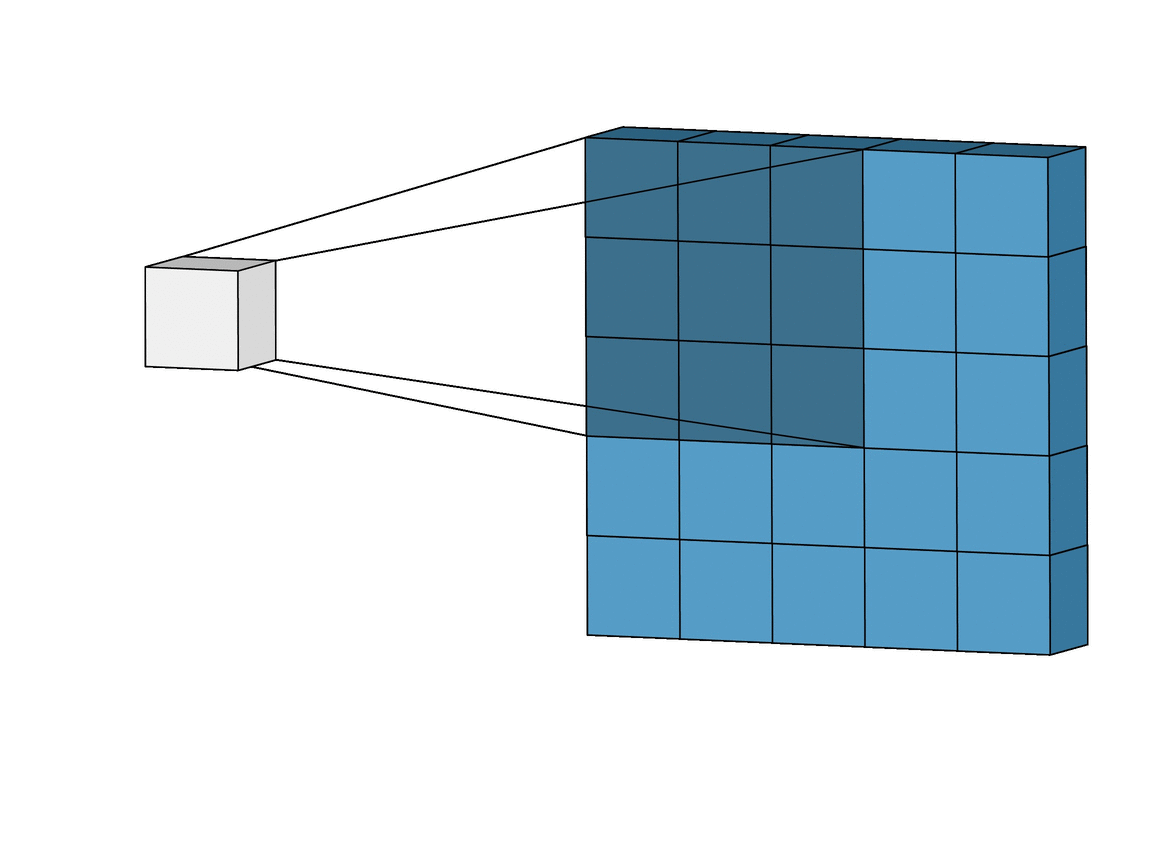

## Maxpooling operation

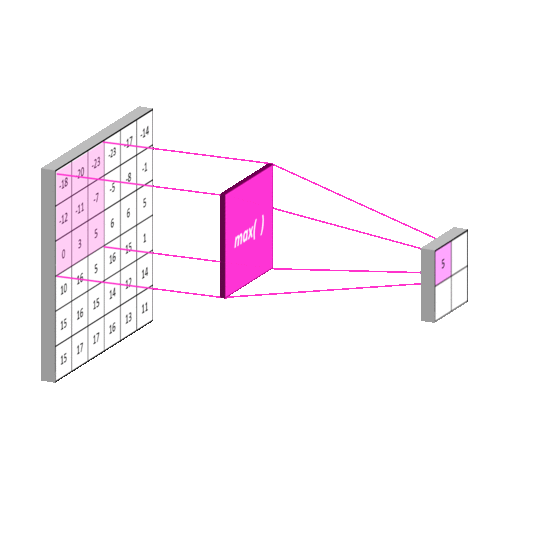

## ReLU activation Function

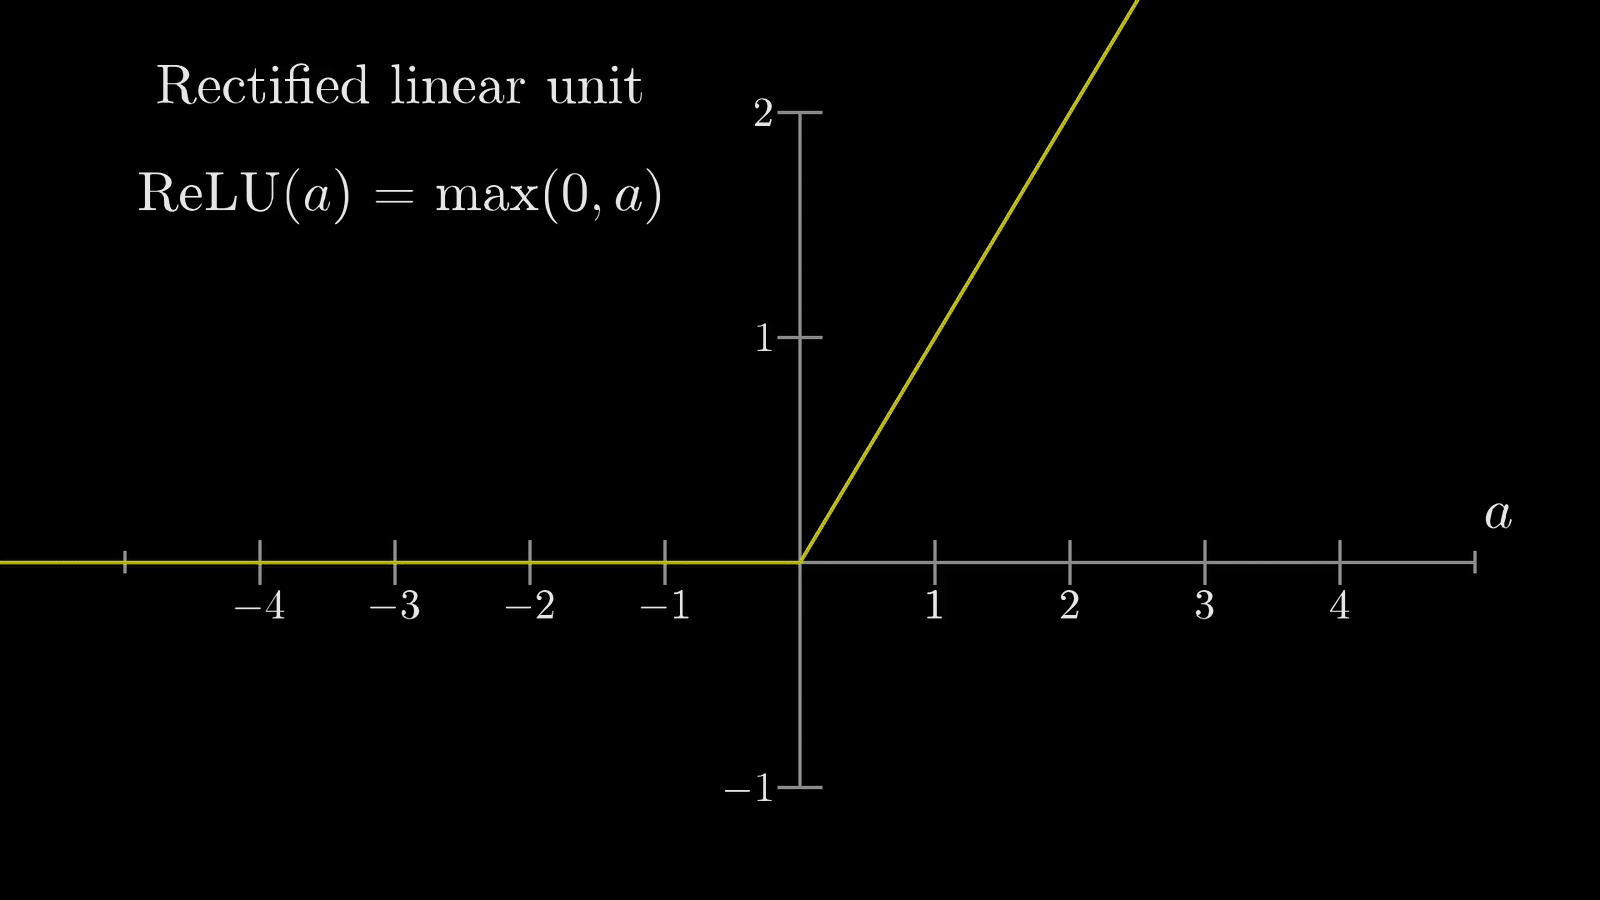

In [13]:
model = nn.Sequential(
                        # 1st convolutional network Layers
                        nn.Conv2d(3,16,(2,2),(1,1),'same'),   # Convolution
                        nn.BatchNorm2d(16),                   # Normalization 
                        nn.ReLU(True),                       # Activation
                        nn.MaxPool2d((2,2)),                 # Pooling
    
                        # 2nd convolutional network Layers
                        nn.Conv2d(16,32,(2,2),(1,1),'same'),  # Convolution
                        nn.BatchNorm2d(32),                  # Normalization 
                        nn.ReLU(True),                       # Activation
                        nn.MaxPool2d((2,2)),                 # Pooling
    
                        # 3rd convolutional network Layers
                        nn.Conv2d(32,64,(2,2),(1,1),'same'), # Convolution
                        nn.BatchNorm2d(64),                  # Normalization 
                        nn.ReLU(True),                       # Activation
                        nn.MaxPool2d((2,2)),                 # Pooling

                        # Flatten Data
                        nn.Flatten(),                        # Flatten
    
                        # feed forward Layers
                        nn.Linear(1024,256),                  # Linear 
                 b       nn.ReLU(True),                       # Activation
                        nn.Linear(256,43)                    # Linear 
                    )

# Send model to Cuda Memory
model = model.to(torch.device('cuda'),non_blocking=True)
# For Model Summary
ts.summary(model,(3,32,32))

C:\Users\Alireza217\anaconda3\envs\traffic-cnn-cuda-py\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:1032.)
  return F.conv2d(input, weight, bias, self.stride,


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             208
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
         MaxPool2d-4           [-1, 16, 16, 16]               0
            Conv2d-5           [-1, 32, 16, 16]           2,080
       BatchNorm2d-6           [-1, 32, 16, 16]              64
              ReLU-7           [-1, 32, 16, 16]               0
         MaxPool2d-8             [-1, 32, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]           8,256
      BatchNorm2d-10             [-1, 64, 8, 8]             128
             ReLU-11             [-1, 64, 8, 8]               0
        MaxPool2d-12             [-1, 64, 4, 4]               0
          Flatten-13                 [-1, 1024]               0
           Linear-14                  [

#### Define the Evaluate Function for model loss and accuracy evaluation and Train Model Function to train the model

In [19]:
def evaluate(model, data, target, batch_size=32):
    model.eval()
    data = data.to(torch.device('cuda'), non_blocking=True)
    target = target.to(torch.device('cuda'), non_blocking=True).long()
    length = len(target)
    total_loss = 0.0
    correct = 0

    with torch.no_grad():
        for i in range(0, length, batch_size):
            batch_data = data[i:i+batch_size]
            batch_target = target[i:i+batch_size]

            yhat = model(batch_data)
            ypred = yhat.argmax(axis=1)
            total_loss += nn.functional.cross_entropy(yhat, batch_target, reduction='sum').item()
            correct += (ypred == batch_target).sum().item()

    avg_loss = total_loss / length
    accuracy = correct / length

    print(f'Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

print('\nInitial Loss and Accuracy on Test Dataset:')
evaluate(model, xtest.float(), ytest, batch_size=32)



Initial Loss and Accuracy on Test Dataset:
Loss: 3.7616, Accuracy: 0.0162


#### Evaluate the Model on test data before training

In [20]:
print('\nInitial Loss and Accuracy on Test Dataset :')
evaluate(model,xtest.float(),ytest)


Initial Loss and Accuracy on Test Dataset :
Loss: 3.7616, Accuracy: 0.0162


#### Define Train Model Function to train the model

In [23]:
import torch
import torch.nn as nn
import gc
import pandas as pd

def train_model(model=model, optimizer=torch.optim.Adam, epochs=5, batch_size=200, steps_per_epochs=200, l2_reg=0, max_lr=0.01, grad_clip=0.5):
    
    hist = [[], [], [], []]  # hist will stores train and test data losses and accuracy of every epochs
    
    train_ds = [(x, y) for x, y in zip(xtrain, ytrain)]  # Prepare training dataset for Data Loader
    training_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size)  # Data Loader used to train model 
    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size * steps_per_epochs) 
                                    # Data Loader for epoch end evaluation on train data
    del train_ds 
    gc.collect()  # Delete the used variable and free up memory
    
    # Initialized the Optimizer to update weights and bias of model parameters
    optimizer = optimizer(model.parameters(), weight_decay=l2_reg)
    
    # Initialized the Schedular to update learning rate as per one cycle poicy  
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=int(steps_per_epochs * 1.01))
        
    # Training Started
    for i in range(epochs):
                 
        print('\nEpoch' , i + 1 , ': [', end="")
        
        # Load Batches of training data loader
        for j, (xb, yb) in enumerate(training_dl):
            
            # move the training batch data to cuda memory for faster processing
            xb = xb.to(torch.device('cuda'), non_blocking=True)
            yb = yb.to(torch.device('cuda'), non_blocking=True).long()  # Ensure target is LongTensor
            
            # Calculate Losses and gradients
            yhat = model(xb.float())
            loss = nn.functional.cross_entropy(yhat, yb)
            loss.backward()
            
            # Clip the outlier like gradients
            nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            # Update Weights and bias
            optimizer.step()
            optimizer.zero_grad()
            
            # Update Learning Rate
            sched.step()
            
            del xb, yb, yhat
            torch.cuda.empty_cache()
            # delete the used data and free up space
            
            # print the training epochs progress
            if j % int(steps_per_epochs / 20) == 0:
                print('.', end='')
                
            # break the loop when all steps of an epoch completed. 
            if steps_per_epochs == j :
                break
                             
        # Epochs end evaluation 
        
        device = torch.device('cuda')  # initialized cuda to device
        
        # load training data batches from train data loader
        for xtrainb, ytrainb in train_dl:
            break
        
        # move train data to cuda
        xtrain_cuda = xtrainb.to(device, non_blocking=True)
        ytrain_cuda = ytrainb.to(device, non_blocking=True).long()  # Ensure target is LongTensor
        del xtrainb, ytrainb
        gc.collect()
        # delete used variables and free up space
        
        # Calculate train loss and accuracy
        yhat = model(xtrain_cuda.float())
        ypred = yhat.argmax(axis=1)
        train_loss = float(nn.functional.cross_entropy(yhat, ytrain_cuda))
        train_acc = float((ypred == ytrain_cuda).sum() / len(ytrain_cuda))
        
        del xtrain_cuda, ytrain_cuda, yhat, ypred
        torch.cuda.empty_cache()
        # delete used variables and free up space
        
        # move test data to cuda
        xtest_cuda = xtest.to(device, non_blocking=True)
        ytest_cuda = ytest.to(device, non_blocking=True).long()  # Ensure target is LongTensor
        
        # Calculate test loss and accuracy
        yhat = model(xtest_cuda.float())
        ypred = yhat.argmax(axis=1)
        val_loss = float(nn.functional.cross_entropy(yhat, ytest_cuda))
        val_acc = float((ypred == ytest_cuda).sum() / len(ytest_cuda))
        
        del xtest_cuda, ytest_cuda, yhat, ypred
        torch.cuda.empty_cache()
        # delete used variables and free up space
        
        # print the captured train and test loss and accuracy at the end of every epochs
        print('] - Train Loss :', round(train_loss, 4), '- Train Accuracy :', round(train_acc, 4),
              '- Val Loss :', round(val_loss, 4), '- Val Accuracy :', round(val_acc, 4))
        
        # store that data into the previously blank initialized hist list 
        hist[0].append(train_loss)
        hist[1].append(val_loss)
        hist[2].append(train_acc)
        hist[3].append(val_acc)
        
    # Initialized all the evaluation history of all epochs to a dict
    history = {'Train Loss': hist[0], 'Val Loss': hist[1], 'Train Accuracy': hist[2], 'Val Accuracy': hist[3]}
    
    # return the history as pandas dataframe
    return pd.DataFrame(history)

# Usage example
print('\nInitial Loss and Accuracy on Test Dataset :')
%%time
history = train_model(model, optimizer=torch.optim.Adam, epochs=25, steps_per_epochs=200, l2_reg=0, max_lr=0.015, grad_clip=0.5)



Initial Loss and Accuracy on Test Dataset :


UsageError: Line magic function `%%time` not found.


#### Train the Model

In [24]:
%%time
history = train_model(model,optimizer=torch.optim.Adam,epochs=25,steps_per_epochs=200,l2_reg=0,max_lr=0.015,grad_clip=0.5)


Epoch 1 : [.....................] - Train Loss : 1.6206 - Train Accuracy : 0.5313 - Val Loss : 1.6547 - Val Accuracy : 0.5225

Epoch 2 : [.....................] - Train Loss : 0.5084 - Train Accuracy : 0.853 - Val Loss : 0.5561 - Val Accuracy : 0.8398

Epoch 3 : [.....................] - Train Loss : 0.2921 - Train Accuracy : 0.9109 - Val Loss : 0.3449 - Val Accuracy : 0.8985

Epoch 4 : [.....................] - Train Loss : 0.2058 - Train Accuracy : 0.9364 - Val Loss : 0.249 - Val Accuracy : 0.9247

Epoch 5 : [.....................] - Train Loss : 0.1614 - Train Accuracy : 0.9514 - Val Loss : 0.2178 - Val Accuracy : 0.9402

Epoch 6 : [.....................] - Train Loss : 0.1131 - Train Accuracy : 0.9659 - Val Loss : 0.1664 - Val Accuracy : 0.9543

Epoch 7 : [.....................] - Train Loss : 0.0915 - Train Accuracy : 0.9714 - Val Loss : 0.1432 - Val Accuracy : 0.9607

Epoch 8 : [.....................] - Train Loss : 0.1004 - Train Accuracy : 0.9725 - Val Loss : 0.1554 - Val Accu

#### Model History

In [25]:
history

Train Loss  Val Loss  Train Accuracy  Val Accuracy
0     1.620650  1.654661        0.531300      0.522547
1     0.508414  0.556075        0.853025      0.839762
2     0.292124  0.344918        0.910925      0.898539
3     0.205784  0.249018        0.936400      0.924655
4     0.161351  0.217764        0.951425      0.940182
5     0.113135  0.166442        0.965925      0.954316
6     0.091477  0.143151        0.971375      0.960720
7     0.100412  0.155395        0.972475      0.963155
8     0.040388  0.091880        0.986750      0.975492
9     0.088647  0.144462        0.975100      0.965447
10    0.093429  0.145206        0.971100      0.960862
11    0.045092  0.094313        0.986700      0.976862
12    0.041642  0.089916        0.988000      0.979911
13    0.032016  0.073974        0.989450      0.980856
14    0.010278  0.051344        0.997000      0.988963
15    0.010792  0.057563        0.996500      0.987781
16    0.003217  0.036968        0.999000      0.991894
17    0.002768  0.034850        0.999250      0.993170
18    0.000096  0.029757        1.000000      0.994588
19    0.000056  0.029555        1.000000      0.994635
20    0.000046  0.029657        1.000000      0.994706
21    0.000042  0.029734        1.000000      0.994682
22    0.000040  0.029778        1.000000      0.994682
23    0.000039  0.029796        1.000000      0.994682
24    0.000039  0.029801        1.000000      0.994682

### model's accuracy before training:
Initial Loss and Accuracy on Test Dataset:
Loss: 3.7616, Accuracy: 0.0162

#### Visualize the Training History

#### Model Classification Report on Test Data

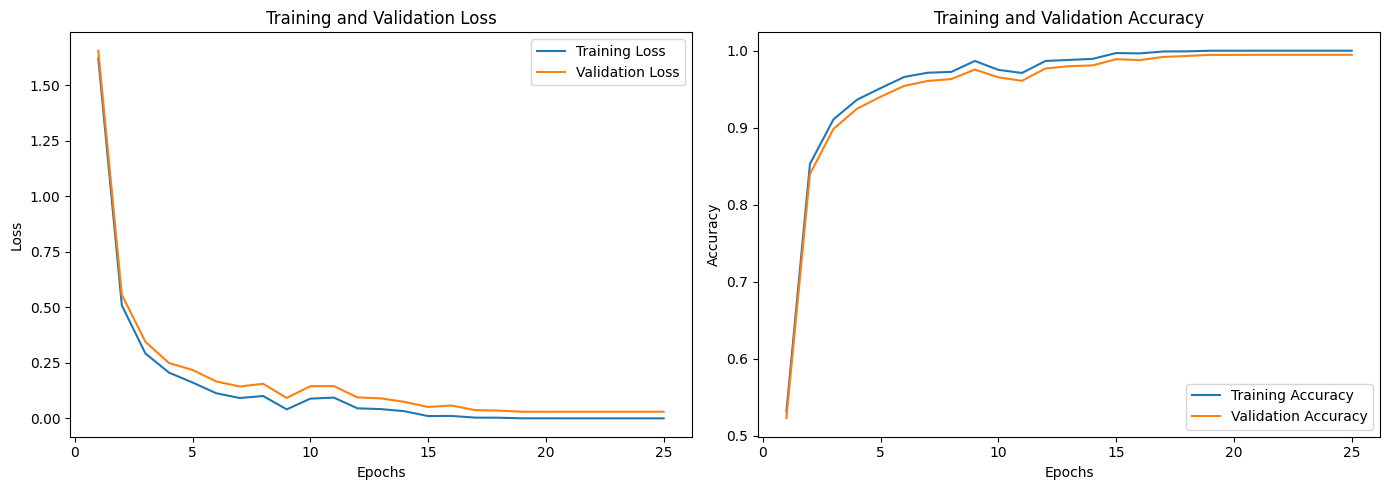

In [12]:
import matplotlib.pyplot as plt

# Data for epochs, training loss, training accuracy, validation loss, and validation accuracy
epochs = list(range(1, 26))
train_loss = [1.6206, 0.5084, 0.2921, 0.2058, 0.1614, 0.1131, 0.0915, 0.1004, 0.0404, 0.0886, 
              0.0934, 0.0451, 0.0416, 0.032, 0.0103, 0.0108, 0.0032, 0.0028, 0.0001, 0.0001, 
              0.0, 0.0, 0.0, 0.0, 0.0]
train_accuracy = [0.5313, 0.853, 0.9109, 0.9364, 0.9514, 0.9659, 0.9714, 0.9725, 0.9867, 0.9751, 
                  0.9711, 0.9867, 0.988, 0.9894, 0.997, 0.9965, 0.999, 0.9992, 1.0, 1.0, 
                  1.0, 1.0, 1.0, 1.0, 1.0]
val_loss = [1.6547, 0.5561, 0.3449, 0.249, 0.2178, 0.1664, 0.1432, 0.1554, 0.0919, 0.1445, 
            0.1452, 0.0943, 0.0899, 0.074, 0.0513, 0.0576, 0.037, 0.0349, 0.0298, 0.0296, 
            0.0297, 0.0297, 0.0298, 0.0298, 0.0298]
val_accuracy = [0.5225, 0.8398, 0.8985, 0.9247, 0.9402, 0.9543, 0.9607, 0.9632, 0.9755, 0.9654, 
                0.9609, 0.9769, 0.9799, 0.9809, 0.989, 0.9878, 0.9919, 0.9932, 0.9946, 0.9946, 
                0.9947, 0.9947, 0.9947, 0.9947, 0.9947]

# Plotting the training and validation loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [27]:
# move to cuda 
xtest =  xtest.to(torch.device('cuda'),non_blocking=True)
# generate predictions
ypred = model(xtest.float()).argmax(axis=1)
# again move back xtest , ypred to cpu
xtest = xtest.to(torch.device('cpu'),non_blocking=True)
ypred = ypred.to(torch.device('cpu'),non_blocking=True)
# calculate the classification metrices and print result 
print(classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.02      1.00      0.05       984
           1       0.00      0.00      0.00       984
           2       0.00      0.00      0.00       984
           3       0.00      0.00      0.00       984
           4       0.00      0.00      0.00       984
           5       0.00      0.00      0.00       984
           6       0.00      0.00      0.00       984
           7       0.00      0.00      0.00       984
           8       0.00      0.00      0.00       984
           9       0.00      0.00      0.00       984
          10       0.00      0.00      0.00       984
          11       0.00      0.00      0.00       984
          12       0.00      0.00      0.00       984
          13       0.00      0.00      0.00       984
          14       0.00      0.00      0.00       984
          15       0.00      0.00      0.00       984
          16       0.00      0.00      0.00       984
          17       0.00    

C:\Users\Alireza217\anaconda3\envs\traffic-cnn-cuda-py\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Alireza217\anaconda3\envs\traffic-cnn-cuda-py\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Alireza217\anaconda3\envs\traffic-cnn-cuda-py\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



#### Create the Prediction Function

In [28]:
def prediction(img):
    if type(img) == str:
        # PIL load the image as PIL object and ToTensor() convert this to a Tensor
        img = tv.transforms.ToTensor()(PIL.Image.open(img))
    # resize image to 32X32 as model supports this
    img = cv2.resize(img.permute(1,2,0).numpy(),(32,32))
    img = torch.from_numpy(img).permute(2,0,1)
    # unsqueezed img as inside a tensor and move to cuda
    img_tensor = img.unsqueeze(0).to(torch.device('cuda'))
    # Predict the label
    pred = int(model(img_tensor).argmax(axis=1)[0])
    # Find the traffic sign name for label from labels_df 
    # that initialize at the begining of the notebook
    pred_str = labels_df[labels_df['ClassId'] == pred]['Name'][pred]
    # Show the image using matplotlib
    plt.figure(figsize=(5,5))
    plt.imshow(cv2.resize(img.permute(1,2,0).numpy(),(1000,1000)))
    plt.axis('off')
    # Print traffic sign that recognized
    print('\nRecognized Traffic Sign :',pred_str,'\n')

#### Some Examples of the above Prediction Function

##### Example 1


Recognized Traffic Sign : Speed limit (50km/h) 



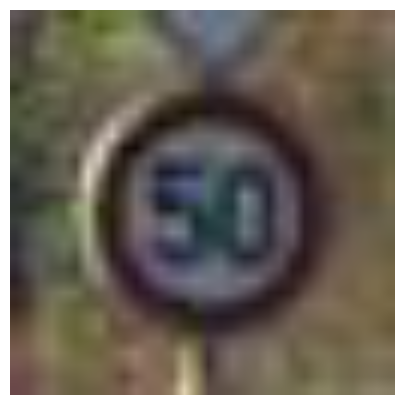

In [35]:
prediction('C:\\Users\\Alireza217\\Desktop\\traffic\\myData\\2\\00000_00017.jpg')

##### Example 2


Recognized Traffic Sign : Keep left 



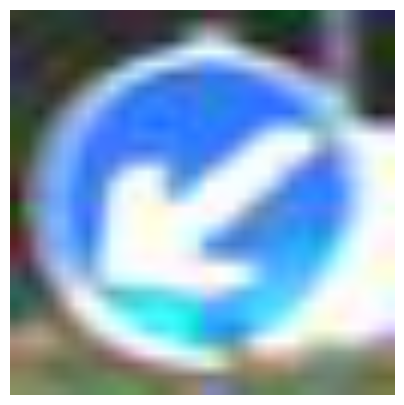

In [59]:
prediction('C:\\Users\\Alireza217\\Desktop\\traffic\\myData\\39\\00000_00019.jpg')

##### Example 3


Recognized Traffic Sign : Road work 



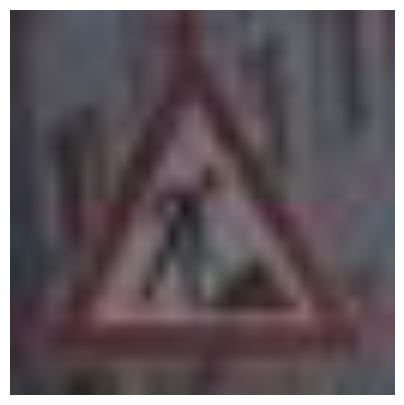

In [38]:
prediction('C:\\Users\\Alireza217\\Desktop\\traffic\\myData\\25\\00000_00029.jpg')

##### Example 4


Recognized Traffic Sign : Speed limit (100km/h) 



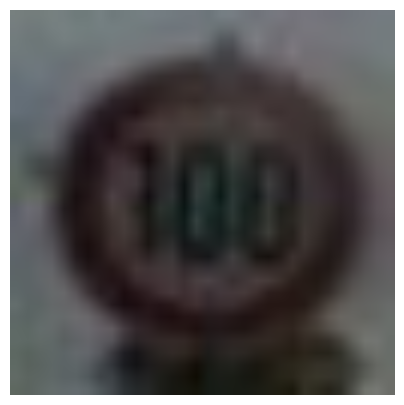

In [41]:
prediction('C:\\Users\\Alireza217\\Desktop\\traffic\\myData\\7\\00000_00025.jpg')

##### Example 5


Recognized Traffic Sign : Stop 



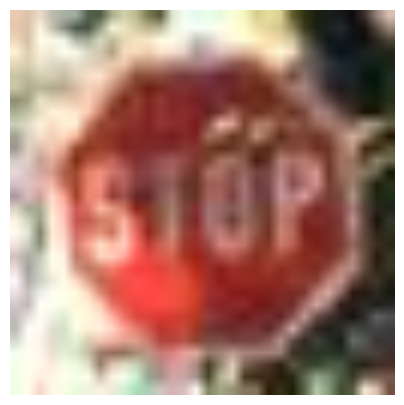

In [43]:
prediction('C:\\Users\\Alireza217\\Desktop\\traffic\\myData\\14\\00000_00019.jpg')

##### Example 6


Recognized Traffic Sign : Bumpy road 



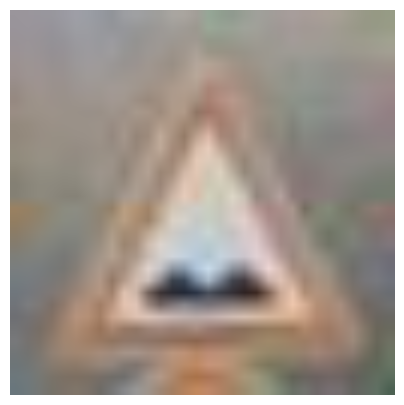

In [46]:
prediction('C:\\Users\\Alireza217\\Desktop\\traffic\\myData\\22\\00000_00019.jpg')

##### Example 6


Recognized Traffic Sign : Speed limit (60km/h) 



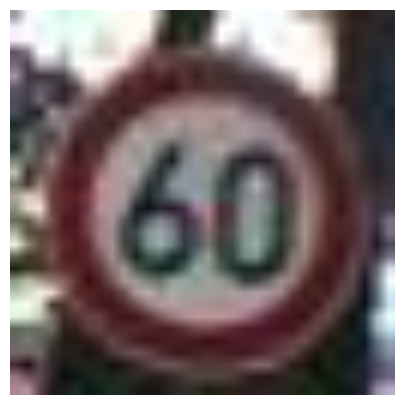

In [47]:
prediction('C:\\Users\\Alireza217\\Desktop\\traffic\\myData\\3\\00000_00019.jpg')

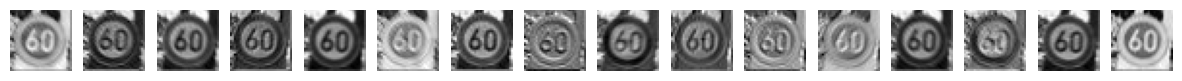

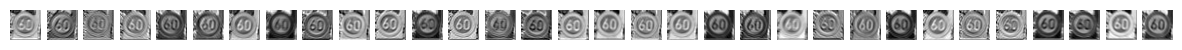

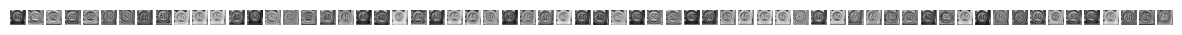

In [63]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define your model (already provided in the question)
model = nn.Sequential(
                        # 1st convolutional network Layers
                        nn.Conv2d(3,16,(2,2),(1,1),'same'),   # Convolution
                        nn.BatchNorm2d(16),                   # Normalization 
                        nn.ReLU(True),                       # Activation
                        nn.MaxPool2d((2,2)),                 # Pooling
    
                        # 2nd convolutional network Layers
                        nn.Conv2d(16,32,(2,2),(1,1),'same'),  # Convolution
                        nn.BatchNorm2d(32),                  # Normalization 
                        nn.ReLU(True),                       # Activation
                        nn.MaxPool2d((2,2)),                 # Pooling
    
                        # 3rd convolutional network Layers
                        nn.Conv2d(32,64,(2,2),(1,1),'same'), # Convolution
                        nn.BatchNorm2d(64),                  # Normalization 
                        nn.ReLU(True),                       # Activation
                        nn.MaxPool2d((2,2)),                 # Pooling

                        # Flatten Data
                        nn.Flatten(),                        # Flatten
    
                        # feed forward Layers
                        nn.Linear(1024,256),                  # Linear 
                        nn.ReLU(True),                       # Activation
                        nn.Linear(256,43)                    # Linear 
                    )

# Move model to GPU
model = model.to(torch.device('cuda'))

# Load and preprocess the image
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Function to extract and visualize feature maps
def visualize_feature_maps(model, image_path):
    # Load and preprocess the image
    image = load_image(image_path).to(torch.device('cuda'))

    # Extract feature maps
    layers = [module for module in model if isinstance(module, nn.Conv2d)]
    feature_maps = []
    x = image
    for layer in layers:
        x = layer(x)
        feature_maps.append(x)

    # Visualize feature maps
    for i, feature_map in enumerate(feature_maps):
        feature_map = feature_map.squeeze(0).cpu().detach().numpy()  # Remove batch dimension and move to CPU
        num_filters = feature_map.shape[0]

        fig, axes = plt.subplots(1, num_filters, figsize=(15, 15))
        for j in range(num_filters):
            if num_filters == 1:
                axes.imshow(feature_map[j], cmap='gray')
            else:
                axes[j].imshow(feature_map[j], cmap='gray')
            axes[j].axis('off')
        plt.show()

# Example usage
image_path = 'C:\\Users\\Alireza217\\Desktop\\traffic\\myData\\3\\00000_00019.jpg' 
visualize_feature_maps(model, image_path)


##### Example 7


Recognized Traffic Sign : Speed limit (50km/h) 



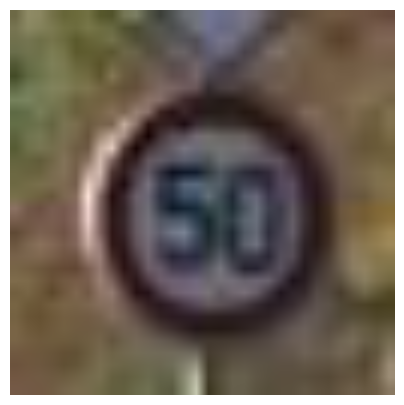

In [48]:
prediction('C:\\Users\\Alireza217\\Desktop\\traffic\\myData\\2\\00000_00019.jpg')

##### Example 7


Recognized Traffic Sign : No entry 



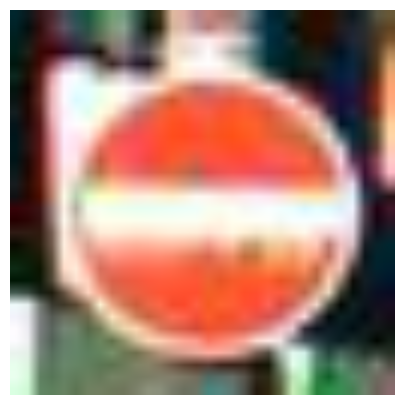

In [49]:
prediction('C:\\Users\\Alireza217\\Desktop\\traffic\\myData\\17\\00000_00019.jpg')

##### Example 8


Recognized Traffic Sign : Dangerous curve to the right 



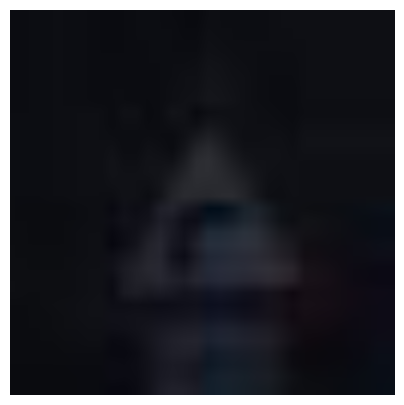

In [50]:
prediction('C:\\Users\\Alireza217\\Desktop\\traffic\\myData\\20\\00000_00019.jpg')

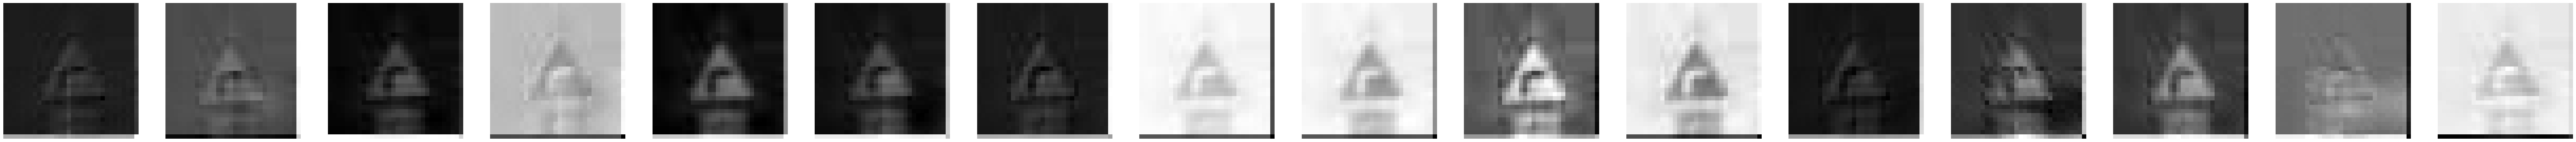

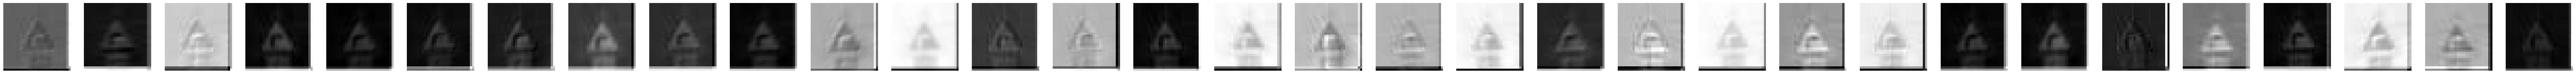

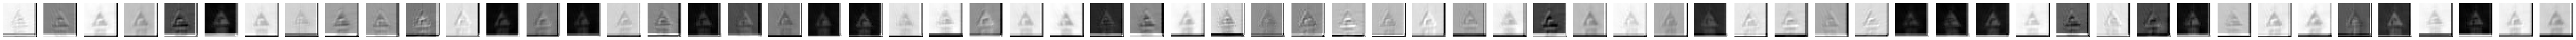

In [11]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define your model (already provided in the question)
model = nn.Sequential(
                        # 1st convolutional network Layers
                        nn.Conv2d(3,16,(2,2),(1,1),'same'),   # Convolution
                        nn.BatchNorm2d(16),                   # Normalization 
                        nn.ReLU(True),                       # Activation
                        nn.MaxPool2d((2,2)),                 # Pooling
    
                        # 2nd convolutional network Layers
                        nn.Conv2d(16,32,(2,2),(1,1),'same'),  # Convolution
                        nn.BatchNorm2d(32),                  # Normalization 
                        nn.ReLU(True),                       # Activation
                        nn.MaxPool2d((2,2)),                 # Pooling
    
                        # 3rd convolutional network Layers
                        nn.Conv2d(32,64,(2,2),(1,1),'same'), # Convolution
                        nn.BatchNorm2d(64),                  # Normalization 
                        nn.ReLU(True),                       # Activation
                        nn.MaxPool2d((2,2)),                 # Pooling

                        # Flatten Data
                        nn.Flatten(),                        # Flatten
    
                        # feed forward Layers
                        nn.Linear(1024,256),                  # Linear 
                        nn.ReLU(True),                       # Activation
                        nn.Linear(256,43)                    # Linear 
                    )

# Move model to GPU
model = model.to(torch.device('cuda'))

# Load and preprocess the image
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Function to extract and visualize feature maps
def visualize_feature_maps(model, image_path):
    # Load and preprocess the image
    image = load_image(image_path).to(torch.device('cuda'))

    # Extract feature maps
    layers = [module for module in model if isinstance(module, nn.Conv2d)]
    feature_maps = []
    x = image
    for layer in layers:
        x = layer(x)
        feature_maps.append(x)

    # Visualize feature maps
    for i, feature_map in enumerate(feature_maps):
        feature_map = feature_map.squeeze(0).cpu().detach().numpy()  # Remove batch dimension and move to CPU
        num_filters = feature_map.shape[0]

        fig, axes = plt.subplots(1, num_filters, figsize=(100, 50))
        for j in range(num_filters):
            if num_filters == 1:
                axes.imshow(feature_map[j], cmap='gray')
            else:
                axes[j].imshow(feature_map[j], cmap='gray')
            axes[j].axis('off')
        plt.show()

# Example usage
image_path = 'C:\\Users\\Alireza217\\Desktop\\traffic\\myData\\20\\00000_00019.jpg' 
visualize_feature_maps(model, image_path)


##### Example 9


Recognized Traffic Sign : Slippery road 



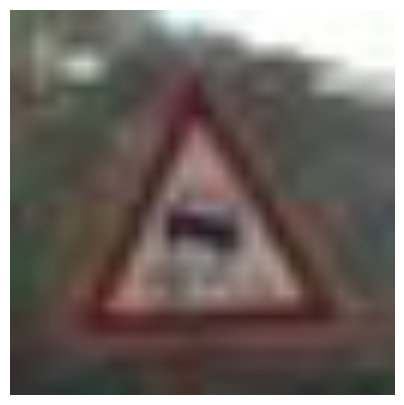

In [54]:
prediction('C:\\Users\\Alireza217\\Desktop\\traffic\\myData\\23\\00000_00022.jpg')

##### Example 10


Recognized Traffic Sign : Turn right ahead 



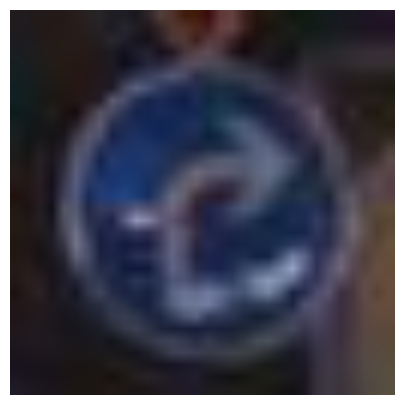

In [56]:
prediction('C:\\Users\\Alireza217\\Desktop\\traffic\\myData\\33\\00000_00019.jpg')

#### Save the Model

In [44]:
torch.save(model,'traffic_sign_recognition.pt')

### Conclusion and Summerization 

Through this entire project, we have build and trained a Convolution Neural Network Model that can recognized traffic signs by processing the images that contains traffic signs. <br>  
The architecture of this model : <br>
3 Convolution layers of 16,32 and 64 number of output channels respectively along with Batch Normalization, Relu Activation and Max Pooling.
Then a flatten layer to flatten the output of last layer into 2-D and apply 2 linear layers with a Relu at the middle where 256 and 43 are the output size respectively. <br><br>
The complete notebook from begining to end follows a Pipeline like import libraries, load dataset, balanced the dataset, split dataset for training and testing, showed 100 of training images as grid, create the model, evaluate the model before training ( to just compare from where to where model improved ), created a train_model function and trained the model with 25 epochs and 200 steps per epochs that takes only 2 - 3 minutes with almost 100% test accuracy. 
In this model training , we also used learning rate one cycle policy scheduling technique to update the learning rate and gradient cliping to limit gradient values.<br>
After the model training, visualize the training history, show the classification report and lastly create a prediction function and predict on some random choosed images.

# <center>**Thank You!**
